In [14]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import warnings
import evidently

warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    elapsed_time = time.time() - t0
    print("{} - done in {:.0f}s".format(title, elapsed_time))
    # Logging durée pour chaque process
    mlflow.log_metric(f"{title}_time", elapsed_time)

# Data preparation / Feature engineering

In [16]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [17]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../ressources/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../ressources/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [18]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../ressources/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [19]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../ressources/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../ressources/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    #df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df],
              ignore_index = True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [20]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../ressources/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [21]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../ressources/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [22]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../ressources/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [23]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

# Credit score function

Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix
Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)
En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy

In [24]:
def credit_cost_function(y_true, y_prob, threshold):
    cost_fp = 100
    cost_fn = 1000

    fn = ((y_true == 1) & (y_prob < threshold)).sum()
    fp = ((y_true == 0) & (y_prob >= threshold)).sum()

    total_cost = (cost_fp * fp) + (cost_fn * fn)
    return total_cost

In [25]:
from sklearn.metrics import mean_squared_error
def credit_cost_function_search_best_threshold(y_true, y_prob):

    best_threshold = 0.5
    best_cost = float('inf')

    for threshold in np.arange(0.05, 1.0, 0.05):  # Parcourir les seuils de 0.1 à 1.0
        cost = credit_cost_function(y_true, y_prob, threshold)
        if cost < best_cost:
            best_threshold = threshold
            best_cost = cost
            print(f'Best cost : {best_cost}')
            print(f'Best Threshold : {best_threshold}')

    # Utiliser le meilleur seuil pour calculer la métrique sur les données de validation
    total_cost = credit_cost_function(y_true, y_prob, best_threshold)
    print(f'Custom Credit Score: {total_cost}')


    return "credit_cost_function", total_cost, None

In [26]:
from sklearn.metrics import mean_squared_error
def credit_cost_function_search_best_threshold_v2(y_true, y_prob):

    best_threshold = 0.5
    best_cost = float('inf')

    for threshold in np.arange(0.00, 1.0, 0.025):  # Parcourir les seuils de 0.1 à 1.0
        cost = credit_cost_function(y_true, y_prob, threshold)
        if cost < best_cost:
            best_threshold = threshold
            best_cost = cost
            #print(f'Best cost : {best_cost}')
            #print(f'Best Threshold : {best_threshold}')

    # Utiliser le meilleur seuil pour calculer la métrique sur les données de validation
    total_cost = credit_cost_function(y_true, y_prob, best_threshold)
    print(f'Custom Credit Score: {total_cost}')


    return total_cost

In [27]:
import datetime


# Pour visualiser les logs lancer 'mlflow ui'

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
experiment_name = f"experiment_dummy_{current_time}"
mlflow.set_experiment('credit_risk_project')
mlflow.start_run()

num_rows = 120000
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    mlflow.log_metric("bureau_balance_rows", bureau.shape[0])
    mlflow.log_metric("bureau_balance_columns", bureau.shape[1])
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    mlflow.log_metric("previous_applications_rows", prev.shape[0])
    mlflow.log_metric("previous_applications_columns", prev.shape[1])
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    mlflow.log_metric("balance_rows", pos.shape[0])
    mlflow.log_metric("balance_columns", pos.shape[1])
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    mlflow.log_metric("payments_rows", ins.shape[0])
    mlflow.log_metric("payments_columns", ins.shape[1])
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    mlflow.log_metric("card_balance_rows", cc.shape[0])
    mlflow.log_metric("card_balance_columns", cc.shape[1])
    del cc
    gc.collect()

#df.to_csv('../ressources/processed_data.csv', index=False)


Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\utils\file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigEx

Train samples: 120000, test samples: 48744
Bureau df shape: (27968, 113)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (92334, 247)
Process previous_applications - done in 2s
Pos-cash balance df shape: (88191, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (53221, 26)
Process installments payments - done in 1s
Credit card balance df shape: (58133, 131)
Process credit card balance - done in 1s


In [28]:
mlflow.end_run()

In [29]:
import re

# Fonction de transformation pour supprimer les caractères spéciaux et mettre en majuscules
def clean_column_name(col_name):
    # Utiliser une expression régulière pour supprimer les caractères spéciaux
    cleaned_name = re.sub(r'\W+', '', col_name)
    # Mettre le nom en majuscules
    cleaned_name_uppercase = cleaned_name.upper()
    return cleaned_name_uppercase

# Renommer les colonnes avec la fonction de transformation
df.rename(columns=clean_column_name, inplace=True)

In [30]:
df.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
count,168741.00000,119997.000000,168741.000000,168741.000000,168741.000000,168741.000000,1.687410e+05,1.687410e+05,168710.000000,1.686440e+05,...,29073.000000,29073.000000,15462.000000,29073.000000,29073.000000,15462.000000,29073.0,29073.0,15462.0,29073.000000
mean,200859.47097,0.081452,0.662169,0.338347,0.307169,0.411975,1.718723e+05,5.750347e+05,27760.496106,5.163046e+05,...,0.000042,0.000172,0.000080,0.002616,0.005538,0.002399,0.0,0.0,0.0,2.060606
std,81407.74005,0.273529,0.472972,0.473149,0.461321,0.717753,3.024190e+05,3.938216e+05,15018.228686,3.621466e+05,...,0.003297,0.013113,0.004521,0.042536,0.082549,0.030119,0.0,0.0,0.0,1.343250
min,100001.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1980.000000,4.500000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
25%,142187.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16875.000000,2.295000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
50%,184373.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.575000e+05,4.904955e+05,25294.500000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.000000
75%,226559.00000,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.819200e+05,35478.000000,6.750000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.000000
max,456250.00000,1.000000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,0.333333,1.000000,0.333333,1.000000,3.000000,0.500000,0.0,0.0,0.0,11.000000


In [31]:
df.isna().sum()

SK_ID_CURR                               0
TARGET                               48744
CODE_GENDER                              0
FLAG_OWN_CAR                             0
FLAG_OWN_REALTY                          0
                                     ...  
CC_NAME_CONTRACT_STATUS_NAN_MAX     139668
CC_NAME_CONTRACT_STATUS_NAN_MEAN    139668
CC_NAME_CONTRACT_STATUS_NAN_SUM     139668
CC_NAME_CONTRACT_STATUS_NAN_VAR     153279
CC_COUNT                            139668
Length: 779, dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168741 entries, 0 to 168743
Columns: 779 entries, SK_ID_CURR to CC_COUNT
dtypes: bool(133), float64(592), int64(42), object(12)
memory usage: 854.3+ MB


In [33]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['CC_NAME_CONTRACT_STATUS_ACTIVE_MIN', 'CC_NAME_CONTRACT_STATUS_ACTIVE_MAX', 'CC_NAME_CONTRACT_STATUS_COMPLETED_MIN', 'CC_NAME_CONTRACT_STATUS_COMPLETED_MAX', 'CC_NAME_CONTRACT_STATUS_DEMAND_MIN', 'CC_NAME_CONTRACT_STATUS_DEMAND_MAX', 'CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MIN', 'CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MAX', 'CC_NAME_CONTRACT_STATUS_SIGNED_MIN', 'CC_NAME_CONTRACT_STATUS_SIGNED_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MIN', 'CC_NAME_CONTRACT_STATUS_NAN_MAX', 'CC_NAME_CONTRACT_STATUS_REFUSED_MIN', 'CC_NAME_CONTRACT_STATUS_APPROVED_MAX', 'CC_NAME_CONTRACT_STATUS_REFUSED_MIN', 'CC_NAME_CONTRACT_STATUS_REFUSED_MAX', 'CC_NAME_CONTRACT_STATUS_APPROVED_MIN']

# Filtrer la liste pour garder uniquement les colonnes qui existent dans df
colonnes_existantes = [col for col in colonnes_a_supprimer if col in df.columns]

# Supprimer les colonnes existantes
df = df.drop(columns=colonnes_existantes)

# Suppression des colonnes avec plus de 80% de valeurs manquantes.

In [35]:

# Calculer le nombre de valeurs manquantes par colonne
missing_values_count = df.isna().sum()

# Calculer le pourcentage de valeurs manquantes pour chaque colonne
percent_missing = missing_values_count / len(df) * 100




In [36]:
missing_values_count

SK_ID_CURR                                 0
TARGET                                 48744
CODE_GENDER                                0
FLAG_OWN_CAR                               0
FLAG_OWN_REALTY                            0
                                       ...  
CC_NAME_CONTRACT_STATUS_SIGNED_VAR    153279
CC_NAME_CONTRACT_STATUS_NAN_MEAN      139668
CC_NAME_CONTRACT_STATUS_NAN_SUM       139668
CC_NAME_CONTRACT_STATUS_NAN_VAR       153279
CC_COUNT                              139668
Length: 767, dtype: int64

In [37]:
# Identifier les colonnes où le pourcentage de valeurs manquantes est supérieur à 80%
columns_to_drop = percent_missing[percent_missing > 80].index

# Afficher les colonnes qui seront supprimées
print("Colonnes à supprimer :", columns_to_drop.tolist())

# Supprimer ces colonnes du DataFrame
df = df.drop(columns=columns_to_drop)

# Afficher les colonnes restantes après suppression
print("Colonnes restantes :", df.columns.tolist())

Colonnes à supprimer : ['BURO_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_VAR', 'BURO_DAYS_CREDIT_ENDDATE_MIN', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_DAYS_CREDIT_UPDATE_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'BURO_AMT_CREDIT_SUM_MAX', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM', 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN', 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN', 'BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'BURO_AMT_ANNUITY_MAX', 'BURO_AMT_ANNUITY_MEAN', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_MONTHS_BALANCE_MIN_MIN', 'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_MONTHS_BALANCE_SIZE_SUM', 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'BURO_CREDIT_ACTIVE_BADDEBT_MEAN', 'BURO_CREDIT_ACTIVE_CLOSED_MEAN', 'BURO_CREDIT_ACTIVE_SOLD_MEAN', 'BURO_CREDIT_ACTIVE_NAN_MEA

In [38]:
df.to_csv('../ressources/processed_data.csv', index=False)

In [39]:
from sklearn.model_selection import train_test_split

train_df = df[df['TARGET'].notnull()]
final_test_df = df[df['TARGET'].isnull()]

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

target_correlation = train_df.corrwith(train_df['TARGET'])


C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [41]:
sorted_correlations = target_correlation.abs().sort_values(ascending=False)

# Sélectionner les 40 caractéristiques les plus corrélées
top_40_features = sorted_correlations.head(40).index.tolist()

In [42]:
target_correlation

SK_ID_CURR                        0.004508
TARGET                            1.000000
CODE_GENDER                      -0.056059
FLAG_OWN_CAR                     -0.020716
FLAG_OWN_REALTY                   0.006211
                                    ...   
INSTAL_AMT_PAYMENT_SUM           -0.016546
INSTAL_DAYS_ENTRY_PAYMENT_MAX     0.025354
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0.039821
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0.033452
INSTAL_COUNT                     -0.014378
Length: 466, dtype: float64

In [43]:
top_40_features

['TARGET',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_EMPLOYED_PERC',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN',
 'NAME_INCOME_TYPE_WORKING',
 'PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN',
 'NAME_EDUCATION_TYPE_HIGHEREDUCATION',
 'CODE_GENDER',
 'PREV_CODE_REJECT_REASON_SCOFR_MEAN',
 'PREV_CODE_REJECT_REASON_XAP_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE_SECONDARYSECONDARYSPECIAL',
 'OCCUPATION_TYPE_LABORERS',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'PREV_NAME_PRODUCT_TYPE_WALKIN_MEAN',
 'NAME_INCOME_TYPE_PENSIONER',
 'FLAG_DOCUMENT_3',
 'EMERGENCYSTATE_MODE_NO',
 'ORGANIZATION_TYPE_XNA',
 'FLAG_EMP_PHONE',
 'FLOORSMAX_MODE',
 'HOUSETYPE_MODE_BLOCKOFFLATS',
 'OWN_CAR_AGE',
 'PREV_NAME_YIELD_GROUP_XNA_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'DAYS_REGISTRATION',
 'AMT_GOODS_PRICE',
 'REG_CITY_NOT_LIVE_CITY',
 'REGION_POPULATION

In [44]:
train_df = train_df[top_40_features]
final_test_df = final_test_df[top_40_features]

In [45]:


X = train_df.drop(columns=['TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Taille de l'ensemble d'entraînement X_train:", X_train.shape)
print("Taille de l'ensemble d'entraînement y_train:", y_train.shape)
print("Taille de l'ensemble de test X_test:", X_test.shape)
print("Taille de l'ensemble de test y_test:", y_test.shape)

gc.collect()



Taille de l'ensemble d'entraînement X_train: (95997, 39)
Taille de l'ensemble d'entraînement y_train: (95997,)
Taille de l'ensemble de test X_test: (24000, 39)
Taille de l'ensemble de test y_test: (24000,)


0

In [46]:
y_train

106183    0.0
119010    0.0
107737    0.0
1364      0.0
8731      0.0
         ... 
110271    0.0
119882    0.0
103697    0.0
860       0.0
15795     1.0
Name: TARGET, Length: 95997, dtype: float64

In [47]:
counts_train = y_train.value_counts()
counts_test = y_test.value_counts()

# Afficher les comptes pour y_train et y_test
print("Comptes pour y_train:")
print(counts_train)
print("\nComptes pour y_test:")
print(counts_test)

Comptes pour y_train:
TARGET
0.0    88209
1.0     7788
Name: count, dtype: int64

Comptes pour y_test:
TARGET
0.0    22014
1.0     1986
Name: count, dtype: int64


In [48]:
y_train.isna().sum()

0

In [49]:
X_train.isna().sum()

EXT_SOURCE_3                                     19007
EXT_SOURCE_2                                       197
EXT_SOURCE_1                                     54021
DAYS_BIRTH                                           0
DAYS_EMPLOYED                                    17210
DAYS_EMPLOYED_PERC                               17210
REGION_RATING_CLIENT_W_CITY                          0
REGION_RATING_CLIENT                                 0
PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN          71398
NAME_INCOME_TYPE_WORKING                             0
PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN           71398
NAME_EDUCATION_TYPE_HIGHEREDUCATION                  0
CODE_GENDER                                          0
PREV_CODE_REJECT_REASON_SCOFR_MEAN               71398
PREV_CODE_REJECT_REASON_XAP_MEAN                 71398
DAYS_LAST_PHONE_CHANGE                               1
DAYS_ID_PUBLISH                                      0
REG_CITY_NOT_WORK_CITY                               0
NAME_EDUCA

In [50]:
num_folds= 5
stratified= False

In [51]:
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [52]:
feats

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_EMPLOYED_PERC',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN',
 'NAME_INCOME_TYPE_WORKING',
 'PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN',
 'NAME_EDUCATION_TYPE_HIGHEREDUCATION',
 'CODE_GENDER',
 'PREV_CODE_REJECT_REASON_SCOFR_MEAN',
 'PREV_CODE_REJECT_REASON_XAP_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE_SECONDARYSECONDARYSPECIAL',
 'OCCUPATION_TYPE_LABORERS',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'PREV_NAME_PRODUCT_TYPE_WALKIN_MEAN',
 'NAME_INCOME_TYPE_PENSIONER',
 'FLAG_DOCUMENT_3',
 'EMERGENCYSTATE_MODE_NO',
 'ORGANIZATION_TYPE_XNA',
 'FLAG_EMP_PHONE',
 'FLOORSMAX_MODE',
 'HOUSETYPE_MODE_BLOCKOFFLATS',
 'OWN_CAR_AGE',
 'PREV_NAME_YIELD_GROUP_XNA_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'DAYS_REGISTRATION',
 'AMT_GOODS_PRICE',
 'REG_CITY_NOT_LIVE_CITY',
 'REGION_POPULATION_RELATIVE',

# Stratégie d’élaboration d’un modèle d’apprentissage supervisé, et sélectionner et entraîner des modèles adaptés à une problématique métier afin de réaliser une analyse prédictive.
 CE1 Vous avez défini sa stratégie d’élaboration d’un modèle pour répondre à un besoin métier
 CE2 Vous avez choisi la ou les variables cibles pertinentes.
 CE3 Vous avez vérifié qu'il n’y a pas de problème de data leakage (c'est-à-dire, des variables trop corrélées à la variable cible et inconnues a priori dans les données en entrée du modèle).
 CE4 Vous avez testé plusieurs algorithmes de façon cohérente, en partant des plus simples vers les plus complexes (au minimum un linéaire et un non linéaire).


In [53]:
import pandas as pd

# Supposons que 'y' est votre Series ou colonne DataFrame contenant les valeurs cibles
class_counts = train_df.value_counts()

# Afficher l'équilibre des classes
print(class_counts)

# Pour obtenir un pourcentage, vous pouvez faire:
class_balance_percentage = (class_counts / class_counts.sum()) * 100
print(class_balance_percentage)

TARGET  EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_1  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_EMPLOYED_PERC  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT  PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN  NAME_INCOME_TYPE_WORKING  PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN  NAME_EDUCATION_TYPE_HIGHEREDUCATION  CODE_GENDER  PREV_CODE_REJECT_REASON_SCOFR_MEAN  PREV_CODE_REJECT_REASON_XAP_MEAN  DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  REG_CITY_NOT_WORK_CITY  NAME_EDUCATION_TYPE_SECONDARYSECONDARYSPECIAL  OCCUPATION_TYPE_LABORERS  FLOORSMAX_AVG  FLOORSMAX_MEDI  PREV_NAME_PRODUCT_TYPE_WALKIN_MEAN  NAME_INCOME_TYPE_PENSIONER  FLAG_DOCUMENT_3  EMERGENCYSTATE_MODE_NO  ORGANIZATION_TYPE_XNA  FLAG_EMP_PHONE  FLOORSMAX_MODE  HOUSETYPE_MODE_BLOCKOFFLATS  OWN_CAR_AGE  PREV_NAME_YIELD_GROUP_XNA_MEAN  INSTAL_DAYS_ENTRY_PAYMENT_MEAN  DAYS_REGISTRATION  AMT_GOODS_PRICE  REG_CITY_NOT_LIVE_CITY  REGION_POPULATION_RELATIVE  PREV_DAYS_DECISION_MEAN  PREV_NAME_GOODS_CATEGORY_XNA_MEAN
0.0     0.000527      0.438361      0.20690

In [54]:
y_series = pd.Series(y)  # où 'y' est votre tableau ou liste de valeurs cibles
class_counts = y_series.value_counts()
print(class_counts)

TARGET
0.0    110223
1.0      9774
Name: count, dtype: int64


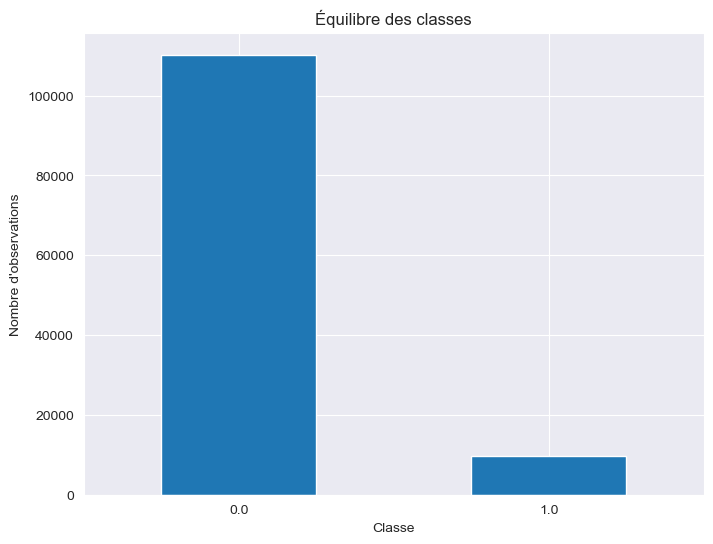

In [55]:
# Création d'un bar plot pour montrer l'équilibre des classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Équilibre des classes')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=0)  # Ajuste l'orientation des étiquettes de l'axe des x
plt.show()

In [56]:
# On constate qu'il n'y a pas de fuite de données liées à une corrélation trop forte avec la TARGET.

# Évaluer les performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.
CE1 Vous avez choisi une métrique adaptée pour évaluer la performance d'un algorithme (par exemple : R2 ou RMSE en régression, accuracy ou AUC en classification, etc.)
Il a mis en oeuvre un score métier pour évaluer les modèles et optimiser les hyperparamètres, qui prend en compte les spécificités du contexte, en particulier le fait que le coût d’un faux négatif et d’un faux positif sont sensiblement différents
CE2 Vous avez exploré d'autres indicateurs de performance que le score pour comprendre les résultats (coefficients des variables en fonction de la pénalisation, visualisation des erreurs en fonction des variables du modèle, temps de calcul...)
CE3 Vous avez séparé les données en train/test pour les évaluer de façon pertinente et détecter l'overfitting
CE4 Vous avez mis en place un modèle simple de référence pour évaluer le pouvoir prédictif du modèle choisi (dummyRegressor ou dummyClassifier)
CE5 Vous avez pris en compte dans sa démarche de modélisation l'éventuel déséquilibre des classes (dans le cas d'une classification).
CE6 Vous avez optimisé les hyper-paramètres pertinents dans les différents algorithmes.
CE7 Vous avez mis en place une validation croisée (via GridsearchCV, RandomizedSearchCV ou équivalent) afin d’optimiser les hyperparamètres et comparer les modèles. Dans le cadre de ce projet :
Une cross-validation du dataset train est réalisée
Un premier test de différentes valeurs d’hyperparamètres est réalisé sur chaque algorithme testé, et affiné pour l’algorithme final choisi
Tout projet présentant un score AUC anormalement élevé, démontrant de l’overfitting dans le GrisSearchCV, sera invalidé (il ne devrait pas être supérieur au meilleur de la compétition Kaggle : 0.82)
CE8 Vous avez présenté l'ensemble des résultats en allant des modèles les plus simples aux plus complexes. Il a justifié le choix final de l'algorithme et des hyperparamètres.
CE9 Vous avez réalisé l’analyse de l’importance des variables (feature importance) globale sur l’ensemble du jeu de données et locale sur chaque individu du jeu de données.

# Définir et mettre en œuvre un pipeline d’entraînement des modèles, avec centralisation du stockage des modèles et formalisation des résultats et mesures des différentes expérimentations réalisées, afin d’industrialiser le projet de Machine Learning.
CE1 Vous avez mis en oeuvre un pipeline d’entraînement des modèles reproductible
CE2 Vous avez sérialisé et stocké les modèles créés dans un registre centralisé afin de pouvoir facilement les réutiliser.
CE3 Vous avez formalisé des mesures et résultats de chaque expérimentation, afin de les analyser et de les comparerdd

In [57]:
def custom_scorer(y_true, y_pred_proba):
    # Recherche du meilleur seuil et calcul du coût
    return credit_cost_function_search_best_threshold_v2(y_true, y_pred_proba)

def auc_scorer(y_true, y_pred_proba):
    return roc_auc_score(y_true, y_pred_proba)

def f1_score_scorer(y_true, y_pred_proba):
    return f1_score(y_true, y_pred_proba)

## DummyClassifier

In [132]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
import mlflow
import datetime
import time


dummy_model = DummyClassifier(strategy="stratified")

# Générer un nom d'expériment unique
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
experiment_name = f"experiment_dummy_{current_time}"

# Créer l'expériment dans MLflow
mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

with mlflow.start_run():

    start_time = time.time()

    dummy_model.fit(X_train, y_train)

    dummy_probs = dummy_model.predict_proba(X_test)[:, 1] # Obtenez la probabilité de la classe positive

    # Calcul de la métrique personnalisée sur le jeu de test
    test_pred_proba = dummy_model.predict_proba(X_test)[:, 1]
    test_cost = custom_scorer(y_test, test_pred_proba)
    mlflow.log_metric('test_custom_cost', test_cost)

    test_auc = auc_scorer(y_test, test_pred_proba)
    mlflow.log_metric('test_auc', test_auc)

    # Calcul et enregistrement du F1 score
    test_pred = dummy_model.predict(X_test)
    test_f1_score = f1_score(y_test, test_pred)
    mlflow.log_metric('test_f1_score', test_f1_score)

    mlflow.log_metric('training_duration', time.time() - start_time)

mlflow.end_run()

Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anacond

Custom Credit Score: 1991700


## LGBMClassifier

### Custom score

Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anacond

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3561
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Custom Credit Score: 1084500
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

C:\Users\PC1\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Custom Credit Score: 1358700


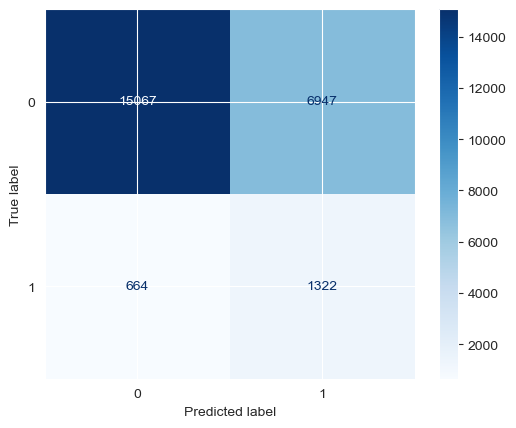

In [124]:
from sklearn.utils import compute_sample_weight
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
import mlflow
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd

# Définissez vos fonctions de coût ici...

# Initialisez vos données ici...
# X_train, X_test, y_train, y_test = ...

# Générer un nom d'expériment unique
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
experiment_name = f"experiment_lightgbm_custom_cost_{current_time}"

# Créer l'expériment dans MLflow
mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# Paramètres pour GridSearchCV
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05],
    # Ajoutez d'autres paramètres ici...
}

# Créer un générateur de validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser le modèle
clf = LGBMClassifier(random_state=42, class_weight='balanced')

# Initialiser GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(custom_scorer, needs_proba=True)
)

try:
    # Entraînement et suivi avec MLflow
    with mlflow.start_run():

        #sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
        
        start_time = time.time()
        #grid_search.fit(X_train, y_train, sample_weight=sample_weight)
        grid_search.fit(X_train, y_train)

        # Enregistrement des meilleurs paramètres et modèle
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        best_estimator = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_estimator, "best_model")

        # Calcul de la métrique personnalisée sur le jeu de test
        test_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
        test_cost = custom_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_custom_cost', test_cost)

        test_auc = auc_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_auc', test_auc)

        # Calcul et enregistrement du F1 score
        test_pred = best_estimator.predict(X_test)
        test_f1_score = f1_score(y_test, test_pred)
        mlflow.log_metric('test_f1_score', test_f1_score)

        # Création et enregistrement de la matrice de confusion
        conf_matrix = confusion_matrix(y_test, test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        cmap = plt.cm.Blues
        disp.plot(cmap=cmap)
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        # Enregistrement de la durée de l'entraînement
        duration = time.time() - start_time
        mlflow.log_metric('training_duration', duration)

        # Sauvegarde optionnelle des résultats de GridSearchCV
        pd.DataFrame(grid_search.cv_results_).to_csv('grid_search_results.csv')
        mlflow.log_artifact('grid_search_results.csv')

except Exception as e:
    print(f"Une erreur est survenue lors de l'entraînement : {e}")

finally:
    mlflow.end_run()


### F1 score

Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anacond

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3561
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3561
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3561
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3561
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6231, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6230, number of negative: 70568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 76798, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 401, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\AppData\Local\Temp\ipykernel

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7788, number of negative: 88209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3600
[LightGBM] [Info] Number of data points in the train set: 95997, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Custom Credit Score: 1358700


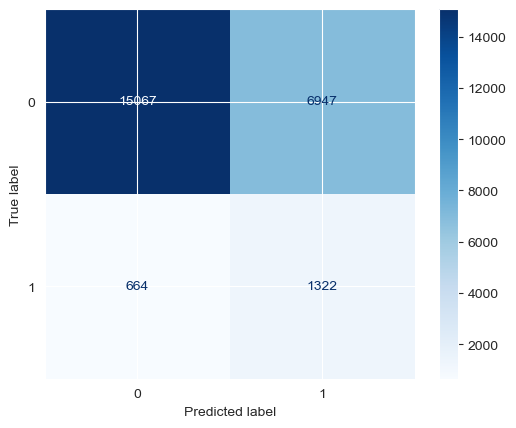

In [125]:
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
import mlflow
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
experiment_name = f"experiment_lightgbm_f1_score_scorer_{current_time}"

mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05]
}

# Créer un générateur de validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = LGBMClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(f1_score_scorer, needs_proba=True)
)

try:
    # Entraînement et suivi avec MLflow
    with mlflow.start_run():

        start_time = time.time()
        #grid_search.fit(X_train, y_train, sample_weight=sample_weight)
        grid_search.fit(X_train, y_train)

        # Enregistrement des meilleurs paramètres et modèle
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        best_estimator = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_estimator, "best_model")

        # Calcul de la métrique personnalisée sur le jeu de test
        test_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
        test_cost = custom_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_custom_cost', test_cost)

        test_auc = auc_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_auc', test_auc)

        # Calcul et enregistrement du F1 score
        test_pred = best_estimator.predict(X_test)
        test_f1_score = f1_score(y_test, test_pred)
        mlflow.log_metric('test_f1_score', test_f1_score)

        # Création et enregistrement de la matrice de confusion
        conf_matrix = confusion_matrix(y_test, test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        cmap = plt.cm.Blues
        disp.plot(cmap=cmap)
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        duration = time.time() - start_time
        mlflow.log_metric('training_duration', duration)

        pd.DataFrame(grid_search.cv_results_).to_csv('grid_search_results.csv')
        mlflow.log_artifact('grid_search_results.csv')

except Exception as e:
    print(f"Une erreur est survenue lors de l'entraînement : {e}")

finally:
    mlflow.end_run()


### AUC score

Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 304, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 397, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1306, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\store\tracking\file_store.py", line 1299, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\mlflow\utils\file_utils.py", line 282, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigEx

[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3503
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 6230, number of negative: 70567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3504
[LightGBM] [Info] Number of data points in the train set: 76797, number of used features: 39
[LightGBM] [Info] [bin

C:\Users\PC1\anaconda3\envs\myenv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Custom Credit Score: 1300100


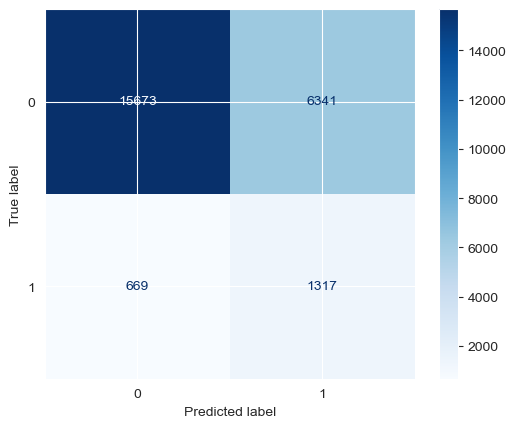

In [58]:
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
import mlflow
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
experiment_name = f"experiment_lightgbm_auc_scorer_{current_time}"

mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05]
}

# Créer un générateur de validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = LGBMClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(auc_scorer, needs_proba=True)
)

try:
    # Entraînement et suivi avec MLflow
    with mlflow.start_run():

        start_time = time.time()
        #grid_search.fit(X_train, y_train, sample_weight=sample_weight)
        grid_search.fit(X_train, y_train)

        # Enregistrement des meilleurs paramètres et modèle
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        best_estimator = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_estimator, "best_model")

        # Calcul de la métrique personnalisée sur le jeu de test
        test_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
        test_cost = custom_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_custom_cost', test_cost)

        test_auc = auc_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_auc', test_auc)

        # Calcul et enregistrement du F1 score
        test_pred = best_estimator.predict(X_test)
        test_f1_score = f1_score(y_test, test_pred)
        mlflow.log_metric('test_f1_score', test_f1_score)

        # Création et enregistrement de la matrice de confusion
        conf_matrix = confusion_matrix(y_test, test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        cmap = plt.cm.Blues
        disp.plot(cmap=cmap)
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        duration = time.time() - start_time
        mlflow.log_metric('training_duration', duration)

        pd.DataFrame(grid_search.cv_results_).to_csv('grid_search_results.csv')
        mlflow.log_artifact('grid_search_results.csv')

except Exception as e:
    print(f"Une erreur est survenue lors de l'entraînement : {e}")

finally:
    mlflow.end_run()

In [59]:
best_estimator.booster_.save_model('model.txt')

In [128]:
   # Récupérer les importances des caractéristiques
feature_importances = best_estimator.feature_importances_

# Création d'un DataFrame pour les importances des caractéristiques
feature_importance_df = pd.DataFrame({
    'feature': feats,
    'importance': feature_importances
})

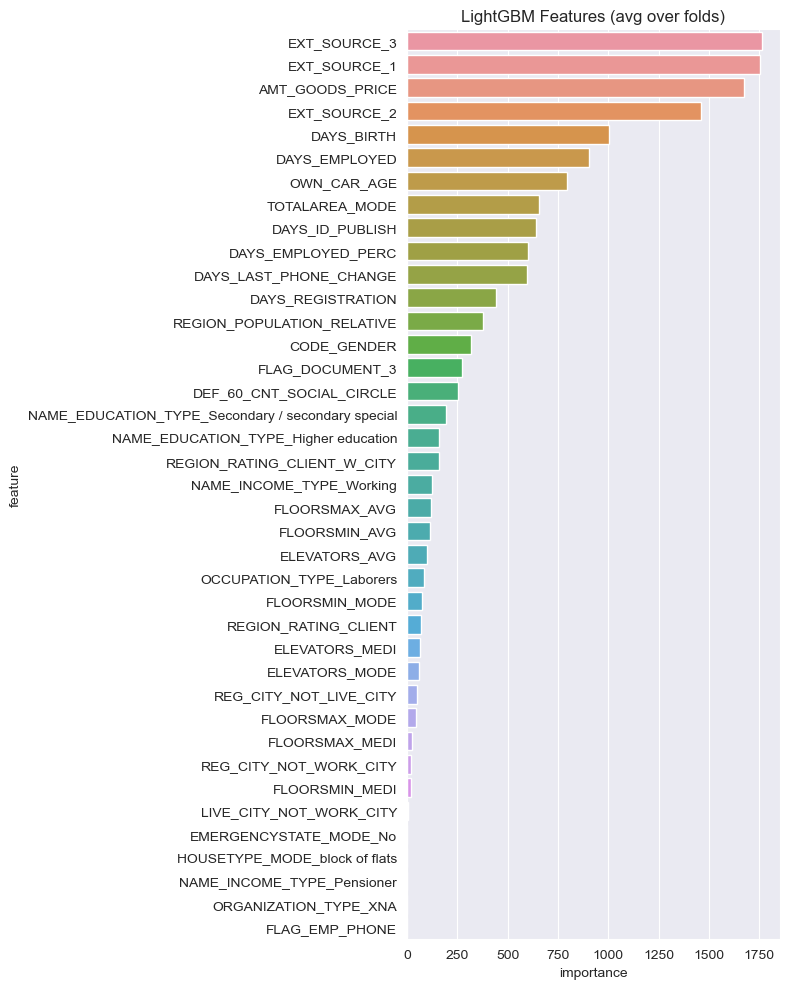

In [129]:
display_importances(feature_importance_df)

In [130]:
feature_importance_df

,feature,importance
0,EXT_SOURCE_3,1764
1,EXT_SOURCE_2,1462
2,EXT_SOURCE_1,1751
3,DAYS_BIRTH,1004
4,DAYS_EMPLOYED,902
5,DAYS_EMPLOYED_PERC,603
6,REGION_RATING_CLIENT_W_CITY,157
7,REGION_RATING_CLIENT,70
8,NAME_INCOME_TYPE_Working,125
9,NAME_EDUCATION_TYPE_Higher education,160


## XGBoost

Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anacond

Custom Credit Score: 1303800


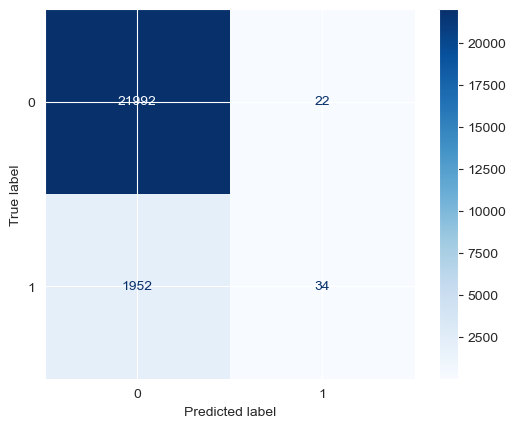

In [131]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import mlflow
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
experiment_name = f"experiment_xgboost_auc_scorer_{current_time}"

mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# Assurez-vous que les fonctions custom_scorer, auc_scorer et f1_score_scorer sont définies correctement

param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.2],
    'max_depth': [3, 10],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(auc_scorer, needs_proba=True)
)

try:
    with mlflow.start_run():

        start_time = time.time()
        #grid_search.fit(X_train, y_train, sample_weight=sample_weight)
        grid_search.fit(X_train, y_train)

        # Enregistrement des meilleurs paramètres et modèle
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        best_estimator = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_estimator, "best_model")

        # Calcul de la métrique personnalisée sur le jeu de test
        test_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
        test_cost = custom_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_custom_cost', test_cost)

        test_auc = auc_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_auc', test_auc)

        # Calcul et enregistrement du F1 score
        test_pred = best_estimator.predict(X_test)
        test_f1_score = f1_score(y_test, test_pred)
        mlflow.log_metric('test_f1_score', test_f1_score)

        # Création et enregistrement de la matrice de confusion
        conf_matrix = confusion_matrix(y_test, test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        cmap = plt.cm.Blues
        disp.plot(cmap=cmap)
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        duration = time.time() - start_time
        mlflow.log_metric('training_duration', duration)

        pd.DataFrame(grid_search.cv_results_).to_csv('grid_search_results.csv')
        mlflow.log_artifact('grid_search_results.csv')

except Exception as e:
    print(f"Une erreur est survenue lors de l'entraînement : {e}")

finally:
    mlflow.end_run()


## Random forest classifier

In [122]:
missing_values_count = X_train.isna().sum()

# Filtrer pour garder uniquement les colonnes avec des valeurs manquantes
missing_values_count = missing_values_count[missing_values_count > 0]

# Trier les colonnes par le nombre de valeurs manquantes, en ordre décroissant
missing_values_count = missing_values_count.sort_values(ascending=False)

In [123]:
missing_values_count

PREV_NAME_GOODS_CATEGORY_XNA_MEAN          71398
PREV_NAME_PRODUCT_TYPE_WALKIN_MEAN         71398
PREV_DAYS_DECISION_MEAN                    71398
PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN    71398
PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN     71398
PREV_CODE_REJECT_REASON_SCOFR_MEAN         71398
PREV_CODE_REJECT_REASON_XAP_MEAN           71398
PREV_NAME_YIELD_GROUP_XNA_MEAN             71398
OWN_CAR_AGE                                63433
INSTAL_DAYS_ENTRY_PAYMENT_MEAN             59641
EXT_SOURCE_1                               54021
FLOORSMAX_MODE                             47752
FLOORSMAX_AVG                              47752
FLOORSMAX_MEDI                             47752
EXT_SOURCE_3                               19007
DAYS_EMPLOYED_PERC                         17210
DAYS_EMPLOYED                              17210
EXT_SOURCE_2                                 197
AMT_GOODS_PRICE                               79
DAYS_LAST_PHONE_CHANGE                         1
dtype: int64

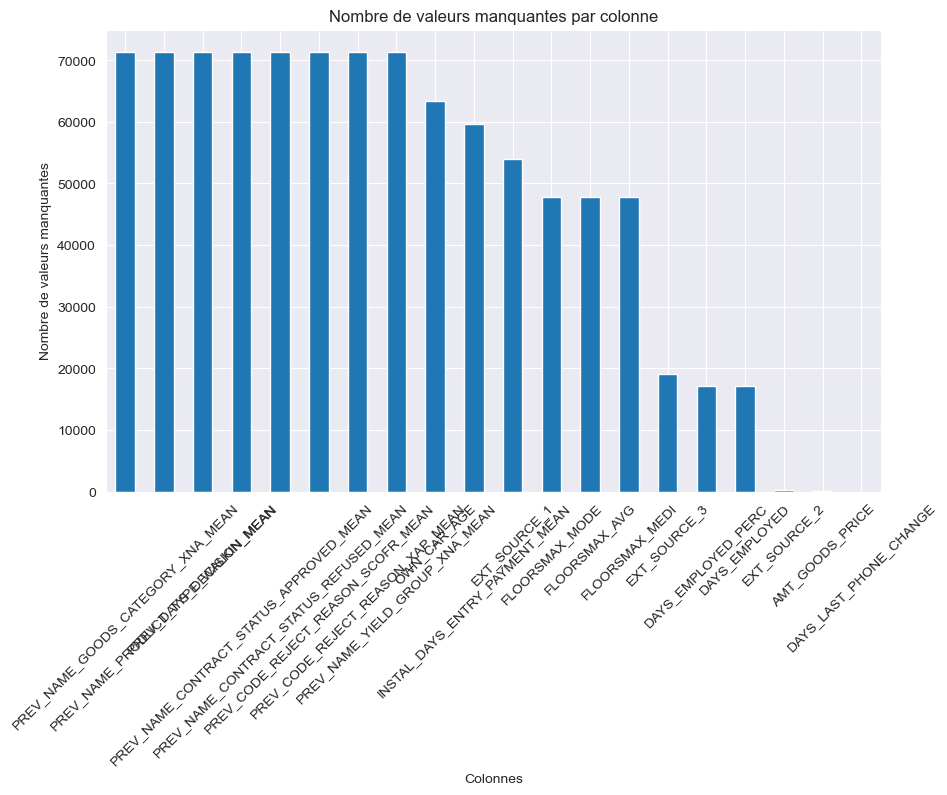

In [124]:
import matplotlib.pyplot as plt

# Créer un graphique en barres des valeurs manquantes
plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.title('Nombre de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs manquantes')
plt.xticks(rotation=45)
plt.show()

In [125]:
# Identifier les colonnes avec des valeurs manquantes
missing_values_cols = X_train.columns[X_train.isna().any()].tolist()
print("Colonnes avec des valeurs manquantes:", missing_values_cols)


Colonnes avec des valeurs manquantes: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN', 'PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN', 'PREV_CODE_REJECT_REASON_SCOFR_MEAN', 'PREV_CODE_REJECT_REASON_XAP_MEAN', 'DAYS_LAST_PHONE_CHANGE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'PREV_NAME_PRODUCT_TYPE_WALKIN_MEAN', 'FLOORSMAX_MODE', 'OWN_CAR_AGE', 'PREV_NAME_YIELD_GROUP_XNA_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'AMT_GOODS_PRICE', 'PREV_DAYS_DECISION_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN']


In [126]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median') # ou 'mean', 'constant'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Traceback (most recent call last):
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anaconda3\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC1\anacond

Custom Credit Score: 1348800


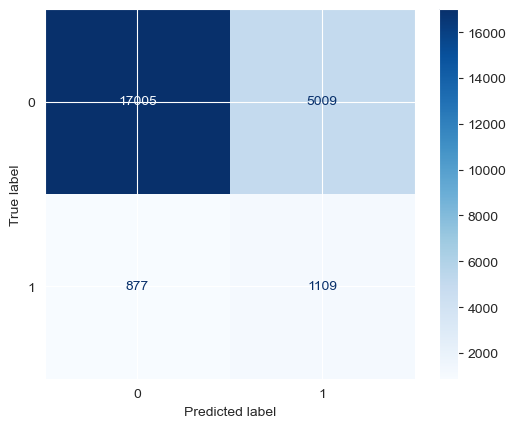

In [129]:
from sklearn.metrics import f1_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import mlflow
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
experiment_name = f"experiment_rf_auc_scorer_{current_time}"

mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10, 30]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    scoring=make_scorer(auc_scorer, needs_proba=True)
)

try:
    with mlflow.start_run():

        start_time = time.time()
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        best_estimator = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_estimator, "best_model")

        test_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
        test_cost = custom_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_custom_cost', test_cost)

        test_auc = auc_scorer(y_test, test_pred_proba)
        mlflow.log_metric('test_auc', test_auc)

        test_pred = best_estimator.predict(X_test)
        test_f1_score = f1_score(y_test, test_pred)
        mlflow.log_metric('test_f1_score', test_f1_score)

        conf_matrix = confusion_matrix(y_test, test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        cmap = plt.cm.Blues
        disp.plot(cmap=cmap)
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        duration = time.time() - start_time
        mlflow.log_metric('training_duration', duration)

        pd.DataFrame(grid_search.cv_results_).to_csv('grid_search_results.csv')
        mlflow.log_artifact('grid_search_results.csv')

except Exception as e:
    print(f"Une erreur est survenue lors de l'entraînement : {e}")

finally:
    mlflow.end_run()


In [ ]:
# Compléxité à ne pas impacter la prédiction à cause de données manquantes qui pourraient venir fausser la prédiction

# Comparaison des modèles via mlflow

In [ ]:
# cmd : mlflow ui --port 1234

# Evidently
Définir et mettre en œuvre une stratégie de suivi de la performance d’un modèle en production et en assurer la maintenance afin de garantir dans le temps la production de prédictions performantes.
CE1 Analyse de data drift entre le dataset train et le dataset test
CE2 Vous avez réalisé un système de stockage d’événements relatifs aux prédictions réalisées par l’API et une gestion d’alerte en cas de dégradation significative de la performance. Dans le cadre du projet :
choix de réaliser a priori cette analyse de data drift, via une simulation dans un notebook et création d’un tableau HTML d’analyse avec la librairie evidently
CE3 Vous avez analysé la stabilité du modèle dans le temps et défini des actions d’amélioration de sa performance. Dans le cadre de ce projet :
Analyse du tableau HTML evidently, et conclusion sur un éventuel data drift

In [80]:
import evidently
from sklearn import datasets
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.ui.dashboards import Dashboard

iris_data = datasets.load_iris()
iris_frame = iris_data.frame


In [76]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

current_data_filtered = final_test_df.sample(random_state=1)
reference_data_filtered = X.sample(random_state=1)

data_drift_report.run(current_data=current_data_filtered, reference_data=reference_data_filtered)

# Enregistrez le tableau de bord au format HTML
data_drift_report.save_html('data_drift_report.html')

C:\Users\PC1\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\PC1\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\PC1\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\PC1\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\PC1\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
C:\Users\PC1\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 